In [1]:

import os
import glob
from pathlib import Path
from typing import Optional, Tuple, Union
import warnings
import argparse


import numpy as np
import pandas as pd


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image


import matplotlib.pyplot as plt
import cv2
from PIL import Image


from diffusers import (
    UNet2DConditionModel,
    UNet2DModel,
    DiffusionPipeline,
    ImagePipelineOutput,
    DDPMScheduler,
    AutoencoderKL,
)


from accelerate import Accelerator
from huggingface_hub import HfFolder, Repository, whoami
from transformers import AutoProcessor, AutoTokenizer, CLIPModel


from FM.adaface import get_adaface_embedding, get_adaface_model

from tqdm.auto import tqdm


/research/iprobe-shuklan3/anaconda3/envs/lcg/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


import argparse

class TrainingConfig:
    def __init__(self):
        self.img_height = 512  # size of image height
        self.img_width = 512  # size of image width
        self.channels = 3  # number of image channels


opt = TrainingConfig()



model = "CompVis/stable-diffusion-v1-4"
autoencoder = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse",cache_dir='./cache').cuda()
autoencoder.requires_grad_(False);


generator=UNet2DModel(in_channels=4,out_channels=8)
generator=torch.nn.DataParallel(generator)
generator.load_state_dict(torch.load('./pretrained/latent-conditional-gan.pth'))

generator=generator.module.cuda()
generator.eval();



In [3]:
with torch.no_grad():
    def get_batch_recon(autoencoder,generator,batch,image =False):
        morph_enc=autoencoder.encode(batch['morphed_image'].cuda()).latent_dist.mode()
        batch_={'B':morph_enc} 
        real_A = Variable(batch_["B"].type(torch.cuda.FloatTensor))
        fake_B = generator(real_A,timestep=0).sample
        fakeb1,fakeb2=fake_B[:,0:4,:,:],fake_B[:,-4:,:,:]
        recon1=autoencoder.decode(fakeb1).sample
        recon2=autoencoder.decode(fakeb2).sample
        return recon1,recon2

adaface=get_adaface_model()


Loaded iResNet model
compatible keys in state_dict 917 / 917
Check


<All keys matched successfully>
Loaded pretrained model from pretrained_model/model.pt


/research/iprobe-shuklan3/anaconda3/envs/lcg/lib/python3.11/site-packages/torch/nn/modules/module.py:2441: UserWarning: for net.input_layer.0.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/research/iprobe-shuklan3/anaconda3/envs/lcg/lib/python3.11/site-packages/torch/nn/modules/module.py:2441: UserWarning: for net.input_layer.1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/research/iprobe-shuklan3/anaconda3/envs/lcg/lib/python3.11/site-packages/torch/nn/modules/module.py:2441: UserWarning: for net.input_laye

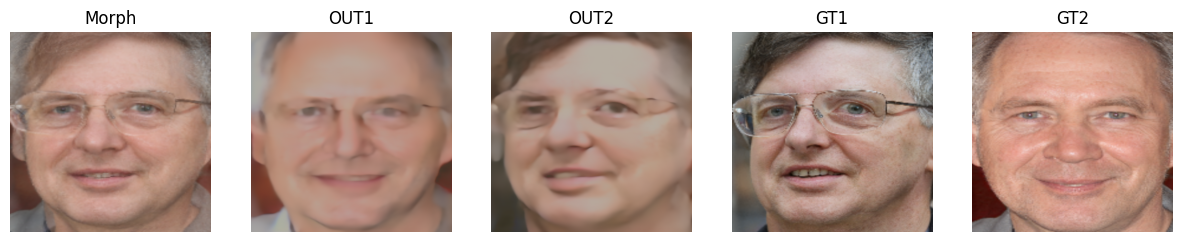

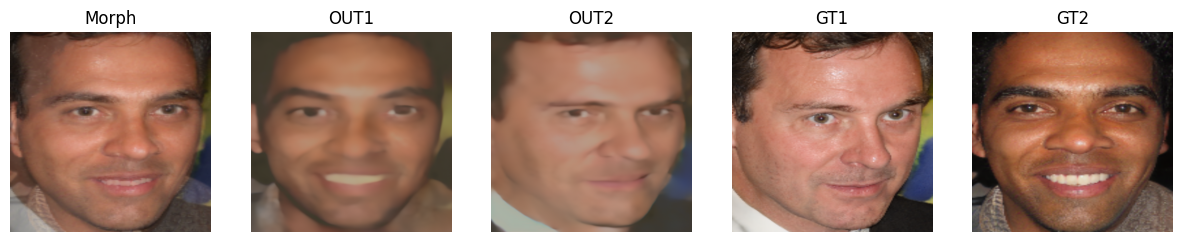

In [4]:
import os
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# Paths
assets_dir = './assets'

# Collect files
morph_files = sorted([os.path.join(assets_dir, f) for f in os.listdir(assets_dir) if f.startswith('morph')])
img1_files  = sorted([os.path.join(assets_dir, f) for f in os.listdir(assets_dir) if f.startswith('img1')])
img2_files  = sorted([os.path.join(assets_dir, f) for f in os.listdir(assets_dir) if f.startswith('img2')])

transform = transforms.Compose([        
        transforms.ToTensor(),
        transforms.Resize((opt.img_height,opt.img_width),antialias=False),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                                transforms.ToPILImage()
                               ])


batch_images = []
for m, i1, i2 in zip(morph_files, img1_files, img2_files):
    morph = transform(Image.open(m))
    img1  = transform(Image.open(i1))
    img2  = transform(Image.open(i2))
    batch_images.append({'morph': morph, 'img1': img1, 'img2': img2})

# Stack tensors into batch
morph_batch = torch.stack([x['morph'] for x in batch_images])
img1_batch  = torch.stack([x['img1'] for x in batch_images])
img2_batch  = torch.stack([x['img2'] for x in batch_images])
batch = {'morphed_image': morph_batch, 'img1': img1_batch, 'img2': img2_batch}

# Run through autoencoder + generator
recon1_batch, recon2_batch = get_batch_recon(autoencoder, generator, batch, image=False)

# Plot all 5 images per sample
all_images = []
for i in range(morph_batch.size(0)):
    morph = invTrans(morph_batch[i])
    recon1 = invTrans(recon1_batch[i])
    recon2 = invTrans(recon2_batch[i])
    gt1 = invTrans(img1_batch[i])
    gt2 = invTrans(img2_batch[i])

    images = [morph, recon1, recon2, gt1, gt2]
    all_images.append(images)
    titles = ['Morph', 'OUT1', 'OUT2', 'GT1', 'GT2']

    plt.figure(figsize=(15,5))
    for j, img in enumerate(images):
        plt.subplot(1,5,j+1)
        plt.imshow(img)  # CHW -> HWC
        plt.title(titles[j])
        plt.axis('off')
    plt.show()




 # AdaFace Similarity

In [5]:
adaface=get_adaface_model()
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
for images in all_images:
    out1, out2 = images[1], images[2]
    gt1, gt2   = images[3], images[4]

    emb_out1 = get_adaface_embedding(adaface, out1)
    emb_out2 = get_adaface_embedding(adaface, out2)
    emb_gt1  = get_adaface_embedding(adaface, gt1)
    emb_gt2  = get_adaface_embedding(adaface, gt2)

    sim1 = cos(emb_out1, emb_gt2).item()
    sim2 = cos(emb_out2, emb_gt1).item()
    print(f"Similarity OUT1-GT1: {sim1:.4f}, OUT2-GT2: {sim2:.4f}")

Loaded iResNet model
compatible keys in state_dict 917 / 917
Check


<All keys matched successfully>
Loaded pretrained model from pretrained_model/model.pt
Similarity OUT1-GT1: 0.2832, OUT2-GT2: 0.7063
Similarity OUT1-GT1: 0.4786, OUT2-GT2: 0.4074
